In [3]:
import time
s = time.time()
from new_methods import *
import geopandas as gpd
import pandas as pd


bfec = gpd.read_file('bfe_mre_all_poc2.shp')
fsp = gpd.read_file('fsp_2.shp')

# Reproject files to UTM
bfec.to_crs(26913, inplace=True)
bfec = bfec[['ELEV', 'geometry']]

fsp.to_crs(26913, inplace=True)
fsp = fsp[['geometry']]
fsp.reset_index(inplace=True)



In [4]:
# Correct broken bfecs if there is any
bfec_bfec = bfec.sjoin(bfec, how='left')
bfec_bfec.reset_index(inplace=True)
brok = bfec_bfec.loc[bfec_bfec['index'] != bfec_bfec['index_right']]
if brok.shape[0] > 0:
    brok_geoms = brok[['index', 'geometry']]
    fix = brok.merge(brok_geoms, left_on='index_right', right_on='index')
    fix['new_geom'] = fix.apply(lambda x: linemerge(list((x.geometry_x, x.geometry_y))), axis=1)
    fix_gpd = gpd.GeoDataFrame(fix[['index_x', 'ELEV_left', 'new_geom']], geometry='new_geom', crs=26913)
    fix_gpd.rename(columns={'index_x': 'index', 'ELEV_left': 'ELEV', 'new_geom': 'geometry'}, inplace=True)
    fix_gpd.set_index('index', inplace=True)
    bfec_clean = bfec.loc[~bfec.index.isin(fix_gpd.index)]
    bfec = pd.concat([bfec_clean, fix_gpd])
    bfec = bfec.drop_duplicates('geometry')
   

In [5]:
def bfe_extend(bfe, fsp):
    bfec = bfe.copy()
    poly_exterior = fsp.geometry.boundary[0]
    bfec['cuts'] = bfec.apply(lambda x: math.ceil(x['geometry'].length / 2), axis=1)
    bfec['points'] = bfec.apply(lambda x: [x.geometry.interpolate(i/x['cuts'], normalized=True) for i in range(1, x['cuts'])], axis=1)

    bfec['fr_ext'] = bfec.apply(lambda x: getExtrapoledLine(x['points'][1].coords[0], x['points'][0].coords[0]), axis=1)
    bfec['ba_ext'] = bfec.apply(lambda x: getExtrapoledLine(x['points'][-2].coords[0], x['points'][-1].coords[0]), axis=1)
    bfec['fr_pt'] = bfec.apply(lambda x: poly_exterior.intersection(x['fr_ext']), axis=1)
    bfec['ba_pt'] = bfec.apply(lambda x: poly_exterior.intersection(x['ba_ext']), axis=1)

    bfec = bfec.loc[(bfec['fr_pt'].geom_type != 'LineString') & (bfec['ba_pt'].geom_type != 'LineString')]

    bfec['fr_pt_near'] = bfec.apply(lambda x: [nearest_points(x['fr_pt'], x['geometry'])[0]], axis=1)
    bfec['ba_pt_near'] = bfec.apply(lambda x: [nearest_points(x['ba_pt'], x['geometry'])[0]], axis=1)
    bfec['new_geom'] = bfec.apply(lambda x: LineString(x['fr_pt_near'] + x['points'] + x['ba_pt_near']), axis=1)
    bfec['new_pts'] = bfec.apply(lambda x: [Point(y) for y in x['new_geom'].coords], axis=1)

    bfec_ex = bfec[['ELEV', 'new_pts', 'geometry']]

    bfec_ex['ends'] = bfec_ex.apply(lambda x: [Point(x.geometry.boundary[0].coords[0]), Point(x.geometry.boundary[1].coords[0])], axis=1)
    bfec_ex['buff'] = bfec_ex.apply(lambda x: (x['ends'][0].buffer(10), x['ends'][1].buffer(10)), axis=1)
    bfec_ex['fr_diff'] = bfec_ex.apply(lambda x: x['buff'][0].difference(fsp.geometry[0]), axis=1)
    bfec_ex['ba_diff'] = bfec_ex.apply(lambda x: x['buff'][1].difference(fsp.geometry[0]), axis=1)
    bfec_ex['frpt'] = bfec_ex.apply(lambda x: [x['fr_diff'].representative_point()], axis=1)
    bfec_ex['bapt'] = bfec_ex.apply(lambda x: [x['ba_diff'].representative_point()], axis=1)

    bfec_ex['new_geom'] = bfec_ex.apply(lambda x: LineString(x['frpt'] + x['new_pts'] + x['bapt']), axis=1)

    bfec_ex = bfec_ex[['ELEV', 'new_geom']]
    bfec_ex.rename(columns={'new_geom': 'geometry'}, inplace=True)
    bfec_ex = bfec_ex.set_geometry('geometry', crs=26913)

    return bfec_ex



In [7]:
fsp_s = gpd.read_file('fsp_splitv3.shp')

In [26]:
fsp.length

0    2840.355641
dtype: float64

In [33]:
fsp = g(fsp_s.iloc[100].geometry, 26913)
fsp.explore()

In [39]:
# 5: FSP Interpolated points along Extent
def fsp_pts(fsp_split, spacing):
    """ Spacing parameter is currently set to 50 (i.e. a point every 50 meters)
    Accomodation for smaller Polygons resets the cut variable to a higher Cut rate 
    to ensure more points along smaller extent. Otherwise, they may get removed during the buffer
    of the IDW algorithm """
    cuts = math.ceil(fsp_split.length / spacing)
    if 3 < cuts < 10: # poly length between 150 and 500 meters. Double Cuts 
        cuts = cuts*2

    geom = [fsp_split.geometry.boundary[0].interpolate(i/cuts, normalized=True) for i in range(1, cuts)]
    fsp_pts = g(geom, 26913)
    
    return fsp_pts

In [38]:
pts = fsp_pts(fsp, spacing=50)
pts.to_file('test_spacing50_small.shp')

In [17]:
fsp

0    95.287741
dtype: float64

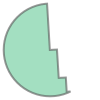

In [476]:
bfec_ex['fr_diff'][0]

In [477]:
diff = bfec_ex[['fr_diff']].set_geometry('fr_diff', crs=26913)
diff.to_file('diff.shp')

In [478]:
bfec_ex['key'] = bfec_ex.apply(lambda x: x['fr_diff'].representative_point(), axis=1)
bfec_ex

,geometry,ends,buff,fr_diff,key
0,"LINESTRING (1261040.168 3638877.425, 1261042.0...","[POINT (1261040.1676500307 3638877.425333949),...",(POLYGON ((1261050.1676500307 3638877.42533394...,"POLYGON ((1261043.994 3638868.187, 1261043.070...",POINT (1261035.942 3638876.934)


In [479]:
key = bfec_ex[['key']].set_geometry('key', crs=26913)
key.to_file('key6.shp')

In [383]:
bfec_ex

,geometry,ends,buff,fr_pts
0,"LINESTRING (1261040.168 3638877.425, 1261042.0...","[POINT (1261040.1676500307 3638877.425333949),...",(POLYGON ((1261045.1676500307 3638877.42533394...,"MULTIPOINT (1261045.168 3638877.425, 1261045.1..."


In [385]:
bfec_ex['fp_intersect'] = bfec_ex['fr_pts'].apply(lambda x: x.disjoint(fsp.boundary[0]))
bfec_ex

,geometry,ends,buff,fr_pts,fp_intersect
0,"LINESTRING (1261040.168 3638877.425, 1261042.0...","[POINT (1261040.1676500307 3638877.425333949),...",(POLYGON ((1261045.1676500307 3638877.42533394...,"MULTIPOINT (1261045.168 3638877.425, 1261045.1...",True


In [352]:
bfec_ex['buff'] = bfec_ex.apply(lambda x: MultiPolygon(x['buff']), axis=1)


In [354]:
bfec_ex

,ELEV,geometry,ends,buff,fr_pts,ba_pts,fp_intersect,key
0,610.0,"LINESTRING (1261040.168 3638877.425, 1261042.0...","[POINT (1261040.1676500307 3638877.425333949),...","MULTIPOLYGON (((1261045.168 3638877.425, 12610...",[POINT (1261045.1676500307 1261045.1435736641)...,"((1261302.2129705825, 3639046.9817691306), (12...",[POINT (1261045.1676500307 1261045.1435736641)...,[POINT (1261045.1676500307 1261045.1435736641)...
1,610.0,"LINESTRING (1263052.704 3639399.056, 1263054.7...","[POINT (1263052.7043505379 3639399.056219292),...","MULTIPOLYGON (((1263057.704 3639399.056, 12630...",[POINT (1263057.7043505379 1263057.6802741713)...,"((1263117.2701987254, 3639399.156728309), (126...",[POINT (1263057.7043505379 1263057.6802741713)...,[POINT (1263057.7043505379 1263057.6802741713)...
2,610.0,"LINESTRING (1261748.987 3639459.814, 1261750.8...","[POINT (1261748.9873735027 3639459.813545743),...","MULTIPOLYGON (((1261753.987 3639459.814, 12617...",[POINT (1261753.9873735027 1261753.9632971361)...,"((1261790.7264852133, 3639470.0272021824), (12...",[POINT (1261753.9873735027 1261753.9632971361)...,[POINT (1261753.9873735027 1261753.9632971361)...
3,612.0,"LINESTRING (1260869.843 3638966.876, 1260869.9...",[POINT (1260869.8433302576 3638966.8761833888)...,"MULTIPOLYGON (((1260874.843 3638966.876, 12608...","[POINT (1260874.8433302576 1260874.819253891),...","((1260942.395024461, 3639183.1871635024), (126...","[POINT (1260874.8433302576 1260874.819253891),...","[POINT (1260874.8433302576 1260874.819253891),..."
4,613.0,"LINESTRING (1263024.328 3639529.343, 1263026.2...","[POINT (1263024.328399205 3639529.343267776), ...","MULTIPOLYGON (((1263029.328 3639529.343, 12630...","[POINT (1263029.328399205 1263029.3043228386),...","((1263073.392895807, 3639531.950685222), (1263...","[POINT (1263029.328399205 1263029.3043228386),...","[POINT (1263029.328399205 1263029.3043228386),..."
...,...,...,...,...,...,...,...,...
272,515.0,"LINESTRING (1269975.475 3635299.463, 1269974.3...","[POINT (1269975.474551583 3635299.4634881015),...","MULTIPOLYGON (((1269980.475 3635299.463, 12699...","[POINT (1269980.474551583 1269980.4504752164),...","((1269458.4680610124, 3634788.3905326384), (12...","[POINT (1269980.474551583 1269980.4504752164),...","[POINT (1269980.474551583 1269980.4504752164),..."
273,516.0,"LINESTRING (1269402.346 3634869.808, 1269403.5...",[POINT (1269402.3455371752 3634869.8077841084)...,"MULTIPOLYGON (((1269407.346 3634869.808, 12694...",[POINT (1269407.3455371752 1269407.3214608086)...,"((1269878.90585241, 3635403.9079749407), (1269...",[POINT (1269407.3455371752 1269407.3214608086)...,[POINT (1269407.3455371752 1269407.3214608086)...
274,517.0,"LINESTRING (1269360.877 3634945.013, 1269361.8...",[POINT (1269360.8768823356 3634945.0131360656)...,"MULTIPOLYGON (((1269365.877 3634945.013, 12693...","[POINT (1269365.8768823356 1269365.852805969),...","((1269722.888781478, 3635588.0941417594), (126...","[POINT (1269365.8768823356 1269365.852805969),...","[POINT (1269365.8768823356 1269365.852805969),..."
275,518.0,"LINESTRING (1269291.720 3635194.507, 1269293.1...",[POINT (1269291.7196517389 3635194.5068923067)...,"MULTIPOLYGON (((1269296.720 3635194.507, 12692...",[POINT (1269296.7196517389 1269296.6955753723)...,"((1269600.6767067255, 3635568.2963380488), (12...",[POINT (1269296.7196517389 1269296.6955753723)...,[POINT (1269296.7196517389 1269296.6955753723)...


In [339]:
key.to_file('key.shp')

AttributeError: 'DataFrame' object has no attribute 'to_file'

In [255]:
fsp_s = split_fsp(fsp, bfec_ex)

In [256]:
fsp_s.to_file('fsp_splitv3.shp')

In [213]:
bfec['fr_pt'].geom_type.value_counts()

Point         267
MultiPoint    137
dtype: int64

In [214]:
bfec['ba_pt'].geom_type.value_counts()

Point         261
MultiPoint    142
LineString      1
dtype: int64

In [204]:
# 2: SPLIT FSP BY bfec
def split_fsp(fsp, bfec):
    fsp_line = fsp.geometry.boundary[0]
    fsp_line = g(fsp_line, 26913)
    fsp_line = fsp_line.explode()

    # Clean up bfec_extension (i.e. ensure only LineStrings occur)
    bfec = bfec.loc[bfec.geom_type == 'LineString']

    # Collect
    lines = bfec['new_geom'].to_list() + fsp_line['geometry'].to_list()
    
    merge = linemerge(lines)
    union = unary_union(merge)
    poly = polygonize(union)
    df = g([p for p in poly], 26913)
    df.reset_index(inplace=True)
    
    return df

In [205]:
fsp_s = split_fsp(fsp, df)

In [207]:
fsp_s.explore()

In [76]:
def extend_bfec(bfec, poly):
    bfec_e = bfec.copy()
    poly_exterior = poly.geometry.boundary[0]
    bfec_e['points'] = bfec_e['geometry'].apply(lambda x: list((x.boundary[0].coords[0], x.boundary[1].coords[0])))
    bfec_e['fr_ext'] = bfec_e.apply(lambda x: getExtrapoledLine(x['points'][0], x['points'][1]), axis=1)
    #bfec_e['ba_ext'] = bfec_e.apply(lambda x: getExtrapoledLine(x['points'][1], x['points'][0]), axis=1)
    bfec_e['fr_pt'] = bfec_e.apply(lambda x: poly_exterior.intersection(x['fr_ext']), axis=1)
    #bfec_e['ba_pt'] = bfec_e.apply(lambda x: poly_exterior.intersection(x['ba_ext']), axis=1)

    #bfec_e = bfec_e.loc[(bfec_e['fr_pt'].geom_type != 'LineString') & (bfec_e['ba_pt'].geom_type != 'LineString')]

    bfec_e['fr_pt_explode'] = bfec_e.apply(lambda x: [y for y in x['fr_pt']] if x['fr_pt'].geom_type == 'MultiPoint' else [x['fr_pt']], axis=1)
    #bfec_e['ba_pt_explode'] = bfec_e.apply(lambda x: [y for y in x['ba_pt']] if x['ba_pt'].geom_type == 'MultiPoint' else [x['ba_pt']], axis=1)
    #bfec_e['ext_geom'] = bfec_e.apply(lambda x: Point(x['fr_pt_explode']), axis=1)
    #bfec_e['ext_geom_scale'] = bfec_e.apply(lambda x: scale(x.geometry, origin='centroid', xfact=1.3, yfact=1.3), axis=1)

    bfec_e = bfec_e[['ELEV', 'fr_pt_explode']]
    #bfec_e.rename(columns={'fr_pt_explode': 'geometry'}, inplace=True)
    #bfec_e = bfec_e.set_geometry('geometry', crs=26913)
    
    return bfec_e
    

In [79]:
bfec_ext = extend_bfec(bfec, fsp)
#bfec_ext.to_file('bfec_fext.shp')
geom = [c for y in bfec_ext['fr_pt_explode'].to_list() for c in y]
g(geom, 26913).to_file('frext.shp')

In [49]:
bfec_e['points'] = bfec_e['geometry'].apply(lambda x: [Point(x.boundary[0].coords[0]), Point(x.boundary[1].coords[0])])
    
geom = [c for p in bfec_e.points.to_list() for c in p]
    pts = g(geom, 26913)
    #bfec_points = bfec_e.set_geometry('points', crs=26913)
    #bfec_points[['points']].to_file('bfec_points.shp')

In [52]:
pts['fr_ext'] = pts.apply(lambda x: getExtrapoledLine(x['geometry'][0]), axis=1)

,geometry
0,POINT (1261040.169 3638877.426)
1,POINT (1261297.211 3639046.980)
2,POINT (1263052.733 3639399.056)
3,POINT (1263112.235 3639399.157)
4,POINT (1261749.039 3639459.828)
...,...
803,POINT (1269717.881 3635588.081)
804,POINT (1269291.743 3635194.532)
805,POINT (1269595.680 3635568.303)
806,POINT (1257549.920 3636839.797)


In [15]:
bfec_extend.to_file('bfec_extended5.shp')

In [4]:
triangles = gpd.GeoDataFrame()
for i, f in fsp.iterrows():
    f = g(f.geometry, 26913)
    print(f)
    bfec_set = bfec.sjoin(f)
    bfec_set = bfec_set[['ELEV', 'geometry']]
    bfec_set = remove_multiline_bfec(bfec_set)
    print('POLY INDEX: ', i)

    #Ignoring Potential Polygon Slivers due to extension of bfecs overlapping small poritions of FSP
    if len(f.sjoin(bfec_set)) == 0:
        continue
    
    # Potential Island poly which will not intersect bfecs. Ignore!
    elif bfec_set.shape[0] == 0:
        continue

    else:
        # Getting Z-geom for bfec Points
        bfec_pts = bfec_zpts(bfec_set)
        
        
        # FSP Simplify, Interpolation, and Z-geom
        fsp_i_pts = (f.pipe(fsp_pts, spacing=50)
                    .pipe(IDW, bfec=bfec_set, power=2)
                    .pipe(ELEV_2geom)
        )

        # Concat and Triangulate
        all_pts = pd.concat([bfec_pts, fsp_i_pts], ignore_index=True)
        all_pts_multigeom = MultiPoint(all_pts.geometry.to_list())

        tin = triangulate(all_pts_multigeom)
        tin_df = g(tin, 26913)

        # Extract Geom
        final_tin = extract_geom(tin_df)
        triangles = pd.concat([triangles, final_tin], ignore_index=True)

                                            geometry
0  POLYGON ((1267332.086 3636427.106, 1267400.261...
POLY INDEX:  0
